# Final Machine Learning in Marketing project

This notebook is done by group 1 as a submission for Machine Learning in Marketing course, Winter Semester 20/21.

Abdallah Maarouf - 611063

Sezen Kilicarslan - 610164

Winnie Leung - 610175

Ecem Selen Seltuk - 610402

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import functions
from sklearn import cluster

Load the data

In [2]:
baskets = pd.read_parquet('baskets.parquet')
coupons = pd.read_parquet('coupons.parquet')
index = pd.read_parquet('coupon_index.parquet')

Take a look at the loaded data

In [3]:
baskets

,week,shopper,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592
...,...,...,...,...
68841593,89,99999,143,470
68841594,89,99999,158,566
68841595,89,99999,186,499
68841596,89,99999,204,496


In [4]:
coupons

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44999995,89,99999,62,40
44999996,89,99999,110,10
44999997,89,99999,37,40
44999998,89,99999,155,25


In [5]:
index

,week,shopper,coupon
0,90,0,0
2000,90,0,1
4000,90,0,2
6000,90,0,3
8000,90,0,4
...,...,...,...
1999,90,1999,0
3999,90,1999,1
5999,90,1999,2
7999,90,1999,3


Add "order ID" to baskets.

Cut the number of shoppers down for processing resources.

In [6]:
nshoppers = 2000
baskets = baskets[baskets.shopper < nshoppers]

Extract unique shopper-product combinations, and creating a dataframe with these unique combos repeated over all weeks. The idea here was to create a dataframe of products, even when not bought this week, but adding the assumption that if a shopper never bought a product it should be irrelevant. 

In [7]:
_combos = baskets.groupby(['shopper','product'])['week'].nunique().reset_index(name='purchases')

In [8]:
_combos.insert(0, 'week', 0)

In [9]:
combos = pd.concat([_combos]*91, ignore_index=True)

In [10]:
combos['week']= (combos.index / (len(combos)/91)).astype(int)

In [11]:
combos

,week,shopper,product,purchases
0,0,0,4,8
1,0,0,11,9
2,0,0,15,1
3,0,0,16,4
4,0,0,21,1
...,...,...,...,...
12927819,90,1999,237,4
12927820,90,1999,242,35
12927821,90,1999,243,1
12927822,90,1999,245,12


Add a ```purchased``` variable, all with value 1 to ```baskets```, and merge it with the new ```combos``` dataframe, changing ```NaN``` values of purchased to ```0```.

In [12]:
baskets.insert(4, 'purchased', 1)

In [13]:
df = pd.merge(baskets, combos, how='right', on=['week', 'shopper', 'product'])

In [14]:
_df = pd.merge(df, coupons, how='left', on=['week', 'shopper', 'product'])

In [15]:
_df

,week,shopper,product,price,purchased,purchases,discount
0,0,0,4,NaN,NaN,8,NaN
1,0,0,11,NaN,NaN,9,NaN
2,0,0,15,NaN,NaN,1,NaN
3,0,0,16,NaN,NaN,4,NaN
4,0,0,21,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...
12927819,90,1999,237,NaN,NaN,4,NaN
12927820,90,1999,242,NaN,NaN,35,NaN
12927821,90,1999,243,NaN,NaN,1,NaN
12927822,90,1999,245,NaN,NaN,12,NaN


In [16]:
df = _df

Adding an order ID for every basket.

In [17]:
df['order_id'] = df.groupby(['week', 'shopper']).ngroup()

We want to fill the ```price``` variable with the undiscounted price, assumed to be the most common value for a product, hence the mode.

In [18]:
_prices = _df.groupby(['product'])['price'].agg(lambda x:x.value_counts().index[0])

In [19]:
prices = _prices.reset_index(name='price1')
prices

,product,price1
0,0,688.0
1,1,560.0
2,2,773.0
3,3,722.0
4,4,620.0
...,...,...
245,245,549.0
246,246,702.0
247,247,670.0
248,248,490.0


In [20]:
df = pd.merge(df, prices, how='right', on=['product'])

In [21]:
df

,week,shopper,product,price,purchased,purchases,discount,order_id,price1
0,0,1,0,NaN,NaN,6,NaN,1,688.0
1,0,15,0,NaN,NaN,5,NaN,15,688.0
2,0,20,0,NaN,NaN,22,NaN,20,688.0
3,0,21,0,NaN,NaN,21,NaN,21,688.0
4,0,23,0,NaN,NaN,2,NaN,23,688.0
...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,NaN,NaN,31,NaN,181991,499.0
12927820,90,1992,249,NaN,NaN,8,NaN,181992,499.0
12927821,90,1996,249,NaN,NaN,44,NaN,181996,499.0
12927822,90,1997,249,NaN,NaN,15,NaN,181997,499.0


In [22]:
df['price'] = df['price'].fillna(df['price1'])

In [23]:
df = df.drop(['price1'], axis=1)

Since missing values of ```purchased``` and ```discount``` means that they weren't purchased, nor offered discount, we filled them with 0s below.

In [24]:
df['purchased'] = df['purchased'].fillna(0)
df['discount'] = df['discount'].fillna(0)
df['price'] = df['price'].astype(int)
df['discount'] = df['discount'].astype(int)
df['purchased'] = df['purchased'].astype(int)
df['order_id'] = df['order_id'].astype(int)
df

,week,shopper,product,price,purchased,purchases,discount,order_id
0,0,1,0,688,0,6,0,1
1,0,15,0,688,0,5,0,15
2,0,20,0,688,0,22,0,20
3,0,21,0,688,0,21,0,21
4,0,23,0,688,0,2,0,23
...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,181991
12927820,90,1992,249,499,0,8,0,181992
12927821,90,1996,249,499,0,44,0,181996
12927822,90,1997,249,499,0,15,0,181997



Now our dataframe is ready with a target variable (purchased).

Adding ```Cumsum``` cumilative sum variable, which refers to how many of this product has this shopper bought so far.

In [25]:
df1 = df.groupby(by=['shopper','product','week'])['purchased'].sum().groupby(level=['shopper','product']).cumsum().reset_index(name='Cumsum')

In [26]:
df1

,shopper,product,week,Cumsum
0,0,4,0,0
1,0,4,1,0
2,0,4,2,0
3,0,4,3,0
4,0,4,4,0
...,...,...,...,...
12927819,1999,249,86,8
12927820,1999,249,87,8
12927821,1999,249,88,8
12927822,1999,249,89,8


The ```Cumsum``` variable would easily leak target variable data to model if implemented directly, we need the sum to include all weeks up until this week but not including it. Subtracting ```purchased``` from ```Cumsum``` should achieve this result.

In [27]:
def subtract_purchased(row):
    return row['Cumsum'] - row['purchased']
df1['Cumsum'] = df1.merge(df[['shopper', 'product', 'week', 'purchased']], on=['shopper', 'product', 'week']).apply(subtract_purchased, axis=1)

In [28]:
df1

,shopper,product,week,Cumsum
0,0,4,0,0
1,0,4,1,0
2,0,4,2,0
3,0,4,3,0
4,0,4,4,0
...,...,...,...,...
12927819,1999,249,86,8
12927820,1999,249,87,8
12927821,1999,249,88,8
12927822,1999,249,89,8


Now, adding 3 variables that explain the recent purchases of the shopper. ```purchase_history_n``` refers to the sum of purchases of this shopper for this product in the last n weeks.

In [29]:
purchase_history_3 = functions.purchase_history_for_all_weeks(3,df,functions.getPurchaseHistories)
purchase_history_4 = functions.purchase_history_for_all_weeks(4,df,functions.getPurchaseHistories)
purchase_history_5 = functions.purchase_history_for_all_weeks(5,df,functions.getPurchaseHistories)

In [30]:
df_2 = pd.merge(df, df1, how='left', on=['week', 'shopper', 'product'])
df_3 = pd.merge(df_2,purchase_history_3 , how='left', on=['week', 'shopper', 'product'])
df_4 = pd.merge(df_3,purchase_history_4 , how='left', on=['week', 'shopper', 'product'])
df_5 = pd.merge(df_4,purchase_history_5 , how='left', on=['week', 'shopper', 'product'])

In [31]:
df_2

,week,shopper,product,price,purchased,purchases,discount,order_id,Cumsum
0,0,1,0,688,0,6,0,1,0
1,0,15,0,688,0,5,0,15,0
2,0,20,0,688,0,22,0,20,0
3,0,21,0,688,0,21,0,21,0
4,0,23,0,688,0,2,0,23,0
...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,181991,31
12927820,90,1992,249,499,0,8,0,181992,8
12927821,90,1996,249,499,0,44,0,181996,44
12927822,90,1997,249,499,0,15,0,181997,15


In [32]:
df_5 = df_5.fillna(0)
df_5

,week,shopper,product,price,purchased,purchases,discount,order_id,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5
0,0,1,0,688,0,6,0,1,0,0,0,0
1,0,15,0,688,0,5,0,15,0,0,0,0
2,0,20,0,688,0,22,0,20,0,0,0,0
3,0,21,0,688,0,21,0,21,0,0,0,0
4,0,23,0,688,0,2,0,23,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,181991,31,0,0,0
12927820,90,1992,249,499,0,8,0,181992,8,0,0,0
12927821,90,1996,249,499,0,44,0,181996,44,0,0,0
12927822,90,1997,249,499,0,15,0,181997,15,0,0,0


Next, checking the cooccurence matrix.

In [33]:
cooccurrence_object = functions.CoOccurrence(df_5[df_5['purchased']==1])

In [34]:
at_cooccurrence = cooccurrence_object.setCategoryCooccurrences('order_id',list(range(0,251,10)), list(range(0,25)))

/home/alex/Desktop/mlim/functions.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['product_categories'] = pd.cut(self.data['product'], bins=bins, labels=labels, right=False)


In [35]:
at_cooccurrence

,category_1,category_2,co-occurrence
0,23,0,6653
1,1,0,9233
2,2,0,13481
3,20,0,10791
4,17,0,9106
...,...,...,...
620,23,24,8057
621,21,24,12673
622,16,24,17148
623,12,24,16394


And also category cooccurance.

/home/alex/Desktop/mlim/functions.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['product_categories'] = pd.cut(self.data['product'], bins=bins, labels=labels, right=False)


co_occurrence_matrix 
 category_2     0      1      2      3      4      5      6      7      8   \
category_1                                                                  
0           42181   9233  13481  13809  17169   6536  21867  18166  12421   
1            9233  41945  11627  12192  15587   5824  18838  16093  12291   
2           13481  11627  55514  14904  21798   6842  29778  19487  14469   
3           13809  12192  14904  51415  20068   7211  26363  18822  15059   
4           17169  15587  21798  20068  73975   8286  32921  22275  20426   
5            6536   5824   6842   7211   8286  23399  10766   9224   6868   
6           21867  18838  29778  26363  32921  10766  78957  31359  22777   
7           18166  16093  19487  18822  22275   9224  31359  63316  18814   
8           12421  12291  14469  15059  20426   6868  22777  18814  50444   
9           11364  12392  14495  15525  18686   7309  21916  16715  15709   
10          18524  21548  23933  22943  37528  10336 

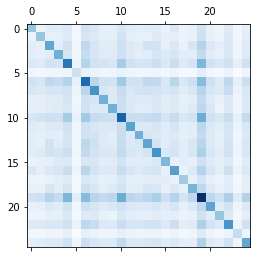

category_2,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
category_1,,,,,,,,,,,,,,,,,,,,,
0,42181,9233,13481,13809,17169,6536,21867,18166,12421,11364,...,9728,17424,9106,10829,21974,10791,8261,15466,6653,12137
1,9233,41945,11627,12192,15587,5824,18838,16093,12291,12392,...,11482,12322,9087,10962,23383,11576,9359,15735,6096,13863
2,13481,11627,55514,14904,21798,6842,29778,19487,14469,14495,...,11478,17905,10225,19115,33006,16878,12569,17296,8299,15583
3,13809,12192,14904,51415,20068,7211,26363,18822,15059,15525,...,16406,19120,13815,13440,27202,14572,11458,17763,7889,15679
4,17169,15587,21798,20068,73975,8286,32921,22275,20426,18686,...,16880,25223,15469,20739,48456,22271,17839,22652,11250,23199
5,6536,5824,6842,7211,8286,23399,10766,9224,6868,7309,...,6265,8148,5154,5597,13133,7209,5106,9607,3482,7789
6,21867,18838,29778,26363,32921,10766,78957,31359,22777,21916,...,17971,31486,17623,24113,45441,23615,15577,29699,11734,24537
7,18166,16093,19487,18822,22275,9224,31359,63316,18814,16715,...,18561,20724,14905,18110,31971,19254,15915,25891,9910,18388
8,12421,12291,14469,15059,20426,6868,22777,18814,50444,15709,...,13885,15686,11537,12949,28541,15185,11023,16785,7699,16057


In [36]:
cooccurrence_object.getCategoryCooccurrences('order_id', list(range(0,251,10)), list(range(0,25)))

In [37]:
products_categories = cooccurrence_object.getProductCategoryTable()
products_categories

,product,product_categories
7,0,0
37404,1,0
107127,2,0
145192,3,0
176000,4,0
...,...,...
12663199,245,24
12706986,246,24
12744289,247,24
12769493,248,24


co_occurrence_matrix 
 category_2     0      1      2      3      4      5      6      7      8   \
category_1                                                                  
0           42181   9233  13481  13809  17169   6536  21867  18166  12421   
1            9233  41945  11627  12192  15587   5824  18838  16093  12291   
2           13481  11627  55514  14904  21798   6842  29778  19487  14469   
3           13809  12192  14904  51415  20068   7211  26363  18822  15059   
4           17169  15587  21798  20068  73975   8286  32921  22275  20426   
5            6536   5824   6842   7211   8286  23399  10766   9224   6868   
6           21867  18838  29778  26363  32921  10766  78957  31359  22777   
7           18166  16093  19487  18822  22275   9224  31359  63316  18814   
8           12421  12291  14469  15059  20426   6868  22777  18814  50444   
9           11364  12392  14495  15525  18686   7309  21916  16715  15709   
10          18524  21548  23933  22943  37528  10336 

/home/alex/Desktop/mlim/functions.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['product_categories'] = pd.cut(self.data['product'], bins=bins, labels=labels, right=False)


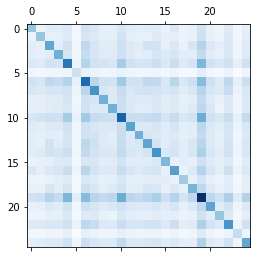

category_2,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
category_1,,,,,,,,,,,,,,,,,,,,,
0,16328,9233,13481,13809,17169,6536,21867,18166,12421,11364,...,9728,17424,9106,10829,21974,10791,8261,15466,6653,12137
1,9233,16328,11627,12192,15587,5824,18838,16093,12291,12392,...,11482,12322,9087,10962,23383,11576,9359,15735,6096,13863
2,13481,11627,16328,14904,21798,6842,29778,19487,14469,14495,...,11478,17905,10225,19115,33006,16878,12569,17296,8299,15583
3,13809,12192,14904,16328,20068,7211,26363,18822,15059,15525,...,16406,19120,13815,13440,27202,14572,11458,17763,7889,15679
4,17169,15587,21798,20068,16328,8286,32921,22275,20426,18686,...,16880,25223,15469,20739,48456,22271,17839,22652,11250,23199
5,6536,5824,6842,7211,8286,16328,10766,9224,6868,7309,...,6265,8148,5154,5597,13133,7209,5106,9607,3482,7789
6,21867,18838,29778,26363,32921,10766,16328,31359,22777,21916,...,17971,31486,17623,24113,45441,23615,15577,29699,11734,24537
7,18166,16093,19487,18822,22275,9224,31359,16328,18814,16715,...,18561,20724,14905,18110,31971,19254,15915,25891,9910,18388
8,12421,12291,14469,15059,20426,6868,22777,18814,16328,15709,...,13885,15686,11537,12949,28541,15185,11023,16785,7699,16057


In [38]:
def rescale_diagonal(_df):
    df = _df.copy()
    np.fill_diagonal(df.values,0)
    df_max = df.mean().mean()
    np.fill_diagonal(df.values,df_max)
    return df

rescaled_categories = rescale_diagonal(cooccurrence_object.getCategoryCooccurrences('order_id', list(range(0,251,10)), list(range(0,25))))
rescaled_categories

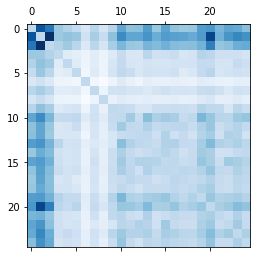

In [39]:
category_clusters = rescaled_categories.to_numpy()
cluster_model = cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 3).fit(category_clusters)
new_order = np.argsort(cluster_model.labels_)
ordered_category_clusters = category_clusters[new_order]
ordered_category_clusters = ordered_category_clusters[:, new_order]
plt.matshow(ordered_category_clusters, cmap = plt.cm.Blues )

In [40]:
df_withcats = pd.merge(df_5, products_categories, on = ['product'])
df_withcats

,week,shopper,product,price,purchased,purchases,discount,order_id,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories
0,0,1,0,688,0,6,0,1,0,0,0,0,0
1,0,15,0,688,0,5,0,15,0,0,0,0,0
2,0,20,0,688,0,22,0,20,0,0,0,0,0
3,0,21,0,688,0,21,0,21,0,0,0,0,0
4,0,23,0,688,0,2,0,23,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,181991,31,0,0,0,24
12927820,90,1992,249,499,0,8,0,181992,8,0,0,0,24
12927821,90,1996,249,499,0,44,0,181996,44,0,0,0,24
12927822,90,1997,249,499,0,15,0,181997,15,0,0,0,24


In [41]:
df_withcats['category_clusters']= pd.cut(df_withcats['product_categories'], bins=[0,4,10,25], labels=[1,2,3], right=False)
df_withcats

,week,shopper,product,price,purchased,purchases,discount,order_id,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters
0,0,1,0,688,0,6,0,1,0,0,0,0,0,1
1,0,15,0,688,0,5,0,15,0,0,0,0,0,1
2,0,20,0,688,0,22,0,20,0,0,0,0,0,1
3,0,21,0,688,0,21,0,21,0,0,0,0,0,1
4,0,23,0,688,0,2,0,23,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,181991,31,0,0,0,24,3
12927820,90,1992,249,499,0,8,0,181992,8,0,0,0,24,3
12927821,90,1996,249,499,0,44,0,181996,44,0,0,0,24,3
12927822,90,1997,249,499,0,15,0,181997,15,0,0,0,24,3


In [42]:
def discounted(x):
    if x>0:
        return 1
    return 0

In [43]:
df_withcats['disc?']=df_withcats['discount'].apply(lambda x:discounted(x))

In [44]:
coupons_withcats = pd.merge(coupons, products_categories, on = ['product'])
coupons_withcats = coupons_withcats.rename(columns={'product': 'product_offered'})
coupons_withcats

,week,shopper,product_offered,discount,product_categories
0,0,0,35,35,3
1,0,16,35,35,3
2,0,34,35,15,3
3,0,157,35,15,3
4,0,283,35,15,3
...,...,...,...,...,...
44999995,89,99799,76,30,7
44999996,89,99858,76,30,7
44999997,89,99863,76,25,7
44999998,89,99866,76,15,7


In [45]:
df_withcats_coupons = pd.merge(df_withcats, coupons_withcats, how='left', on=['week', 'shopper', 'product_categories'])

In [46]:
comparison_column = np.where((df_withcats_coupons["product"] != df_withcats_coupons["product_offered"]) & (pd.notna(df_withcats_coupons['product_offered'])), 1, 0)
comparison_column

array([1, 0, 0, ..., 0, 0, 0])

In [47]:
df_withcats_coupons['despite_coupon']=comparison_column
df_withcats_coupons.columns

Index(['week', 'shopper', 'product', 'price', 'purchased', 'purchases',
       'discount_x', 'order_id', 'Cumsum', 'purchase_history_3',
       'purchase_history_4', 'purchase__history_5', 'product_categories',
       'category_clusters', 'disc?', 'product_offered', 'discount_y',
       'despite_coupon'],
      dtype='object')

Is the shopper indifferent to price changes?

In [48]:
df_withcats_coupons = df_withcats_coupons.reset_index(drop=True)

In [49]:
bcd = df_withcats_coupons.groupby(['shopper', 'product'], as_index=False).agg({'price': 'nunique'})
bcd = bcd.rename(columns={'price': 'indiff_to_price'})
bcd['indiff_to_price']=np.where(bcd['indiff_to_price']==1, 0, 1)
bcd

,shopper,product,indiff_to_price
0,0,4,0
1,0,11,0
2,0,15,0
3,0,16,1
4,0,21,0
...,...,...,...
142059,1999,237,0
142060,1999,242,1
142061,1999,243,0
142062,1999,245,1


In [50]:
df_withcats_coupons = pd.merge(df_withcats_coupons, bcd, how='left', on=['shopper', 'product'])

In [51]:
df_withcats_coupons

,week,shopper,product,price,purchased,purchases,discount_x,order_id,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,product_offered,discount_y,despite_coupon,indiff_to_price
0,0,1,0,688,0,6,0,1,0,0,0,0,0,1,0,7.0,15.0,1,0
1,0,15,0,688,0,5,0,15,0,0,0,0,0,1,0,NaN,NaN,0,1
2,0,20,0,688,0,22,0,20,0,0,0,0,0,1,0,NaN,NaN,0,1
3,0,21,0,688,0,21,0,21,0,0,0,0,0,1,0,NaN,NaN,0,1
4,0,23,0,688,0,2,0,23,0,0,0,0,0,1,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,181991,31,0,0,0,24,3,0,NaN,NaN,0,0
12927820,90,1992,249,499,0,8,0,181992,8,0,0,0,24,3,0,NaN,NaN,0,0
12927821,90,1996,249,499,0,44,0,181996,44,0,0,0,24,3,0,NaN,NaN,0,1
12927822,90,1997,249,499,0,15,0,181997,15,0,0,0,24,3,0,NaN,NaN,0,1


Does the shopper buy only in presence of a coupon?

In [52]:
comparing = np.where((df_withcats_coupons["disc?"] == 1) & (df_withcats_coupons["indiff_to_price"] == 0), 1, 0)
df_withcats_coupons['only_with_coup']=comparing
df_withcats_coupons

,week,shopper,product,price,purchased,purchases,discount_x,order_id,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,product_offered,discount_y,despite_coupon,indiff_to_price,only_with_coup
0,0,1,0,688,0,6,0,1,0,0,0,0,0,1,0,7.0,15.0,1,0,0
1,0,15,0,688,0,5,0,15,0,0,0,0,0,1,0,NaN,NaN,0,1,0
2,0,20,0,688,0,22,0,20,0,0,0,0,0,1,0,NaN,NaN,0,1,0
3,0,21,0,688,0,21,0,21,0,0,0,0,0,1,0,NaN,NaN,0,1,0
4,0,23,0,688,0,2,0,23,0,0,0,0,0,1,0,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,181991,31,0,0,0,24,3,0,NaN,NaN,0,0,0
12927820,90,1992,249,499,0,8,0,181992,8,0,0,0,24,3,0,NaN,NaN,0,0,0
12927821,90,1996,249,499,0,44,0,181996,44,0,0,0,24,3,0,NaN,NaN,0,1,0
12927822,90,1997,249,499,0,15,0,181997,15,0,0,0,24,3,0,NaN,NaN,0,1,0


Average size of coupons given to a shopper in each category.

In [53]:
df_withcats_coupons = df_withcats_coupons.drop(['product_offered','discount_y','order_id'], axis=1)
df_withcats_coupons

,week,shopper,product,price,purchased,purchases,discount_x,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,despite_coupon,indiff_to_price,only_with_coup
0,0,1,0,688,0,6,0,0,0,0,0,0,1,0,1,0,0
1,0,15,0,688,0,5,0,0,0,0,0,0,1,0,0,1,0
2,0,20,0,688,0,22,0,0,0,0,0,0,1,0,0,1,0
3,0,21,0,688,0,21,0,0,0,0,0,0,1,0,0,1,0
4,0,23,0,688,0,2,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,31,0,0,0,24,3,0,0,0,0
12927820,90,1992,249,499,0,8,0,8,0,0,0,24,3,0,0,0,0
12927821,90,1996,249,499,0,44,0,44,0,0,0,24,3,0,0,1,0
12927822,90,1997,249,499,0,15,0,15,0,0,0,24,3,0,0,1,0


Next, we get the purchase cycle for every shopper-product. It's the position this week's in in the average purchase cycle of a shopper. 0 meaning it has been just bought week before, and 1 meaning it's been 1 cycle since last purchased.

In [55]:
purchase_cycle = functions.get_purchase_cycle(df_withcats_coupons)

In [56]:
purchase_cycle.fillna(0,inplace=True)
purchase_cycle

,shopper,product,purchase_cycle,week
0,0,4,0.000000,1
1,0,11,0.000000,1
2,0,15,0.000000,1
3,0,16,0.000000,1
4,0,21,0.000000,1
...,...,...,...,...
142059,1999,237,0.182927,89
142060,1999,242,1.214286,89
142061,1999,243,0.000000,89
142062,1999,245,2.923077,89


In [57]:
df_final = pd.merge(df_withcats_coupons,purchase_cycle, how= 'left',on= ['shopper','product','week'])
df_final

,week,shopper,product,price,purchased,purchases,discount_x,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,despite_coupon,indiff_to_price,only_with_coup,purchase_cycle
0,0,1,0,688,0,6,0,0,0,0,0,0,1,0,1,0,0,NaN
1,0,15,0,688,0,5,0,0,0,0,0,0,1,0,0,1,0,NaN
2,0,20,0,688,0,22,0,0,0,0,0,0,1,0,0,1,0,NaN
3,0,21,0,688,0,21,0,0,0,0,0,0,1,0,0,1,0,NaN
4,0,23,0,688,0,2,0,0,0,0,0,0,1,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927819,90,1991,249,499,0,31,0,31,0,0,0,24,3,0,0,0,0,NaN
12927820,90,1992,249,499,0,8,0,8,0,0,0,24,3,0,0,0,0,NaN
12927821,90,1996,249,499,0,44,0,44,0,0,0,24,3,0,0,1,0,NaN
12927822,90,1997,249,499,0,15,0,15,0,0,0,24,3,0,0,1,0,NaN


Next, we're adding the feature "weeks since last purchased" as ```last_occurance```.

In [58]:
dft = functions.weeks_since_last_purchase(df_final)

In [59]:
dft['last_occurance'] = dft['last_occurance'].fillna(0)
dft

,week,shopper,product,price,purchased,purchases,discount_x,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,despite_coupon,indiff_to_price,only_with_coup,purchase_cycle,last_occurance
175994,0,0,4,620,0,8,0,0,0,0,0,0,1,0,1,0,0,NaN,0.0
176543,1,0,4,620,0,8,0,0,0,0,0,0,1,0,1,0,0,0.000000,0.0
177092,2,0,4,620,0,8,0,0,0,0,0,0,1,0,1,0,0,0.000000,0.0
177641,3,0,4,620,0,8,0,0,0,0,0,0,1,0,0,0,0,0.000000,0.0
178190,4,0,4,620,0,8,0,0,0,0,0,0,1,0,0,0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12924435,86,1999,249,499,0,8,0,8,0,0,0,24,3,0,1,1,0,4.617021,31.0
12925282,87,1999,249,499,0,8,0,8,0,0,0,24,3,0,0,1,0,4.765957,32.0
12926129,88,1999,249,499,0,8,0,8,0,0,0,24,3,0,0,1,0,4.914894,33.0
12926976,89,1999,249,499,0,8,0,8,0,0,0,24,3,0,1,1,0,5.063830,34.0


In [60]:
dft[(dft['shopper'] == 25) & (dft['discount_x'] > 0)]

,week,shopper,product,price,purchased,purchases,discount_x,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,despite_coupon,indiff_to_price,only_with_coup,purchase_cycle,last_occurance
2882,7,25,0,688,0,4,10,0,0,0,0,0,1,1,0,1,0,0.000000,0.0
10691,26,25,0,550,1,4,20,0,0,0,0,0,1,1,0,1,0,0.000000,0.0
18500,45,25,0,412,1,4,40,2,0,0,0,0,1,1,0,1,0,8.500000,17.0
28775,70,25,0,688,0,4,15,3,0,0,0,0,1,1,0,1,0,2.631579,25.0
36584,89,25,0,688,0,4,20,4,0,0,0,0,1,1,0,1,0,0.500000,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10960156,8,25,210,621,0,12,30,1,1,1,1,21,3,1,0,0,1,0.000000,1.0
10987318,62,25,210,621,0,12,25,7,1,1,1,21,3,1,0,0,1,0.111111,1.0
11276113,75,25,215,623,0,2,30,2,0,0,0,21,3,1,0,0,1,2.700000,54.0
12290896,27,25,237,466,0,13,40,6,1,2,3,23,3,1,0,1,0,0.217391,1.0


In [61]:
df_final = dft

Here marks the end of our feature engineering, now to split the data set to known and unknown sets, weeks 0 to 89 for known in ```df_final``` and week 90 for unknown in ```sub```.

In [62]:
sub = df_final[df_final['week']==90] 

In [63]:
sub

,week,shopper,product,price,purchased,purchases,discount_x,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,despite_coupon,indiff_to_price,only_with_coup,purchase_cycle,last_occurance
225404,90,0,4,620,0,8,0,8,0,0,0,0,1,0,0,0,0,NaN,20.0
574822,90,0,11,611,0,9,0,9,0,0,0,1,1,0,0,0,0,NaN,6.0
772082,90,0,15,620,0,1,0,1,0,0,0,1,1,0,0,0,0,NaN,80.0
830371,90,0,16,743,0,4,0,4,0,0,0,1,1,0,0,1,0,NaN,2.0
1048124,90,0,21,463,0,1,0,1,0,0,0,2,1,0,0,0,0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12335049,90,1999,237,466,0,4,0,4,0,0,0,23,3,0,0,0,0,NaN,6.0
12568555,90,1999,242,511,0,35,0,35,0,0,0,24,3,0,0,1,0,NaN,4.0
12620880,90,1999,243,490,0,1,0,1,0,0,0,24,3,0,0,0,0,NaN,42.0
12706966,90,1999,245,549,0,12,0,12,0,0,0,24,3,0,0,1,0,NaN,1.0


In [64]:
df_final = df_final[df_final['week']<90]

In [65]:
df_final

,week,shopper,product,price,purchased,purchases,discount_x,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,despite_coupon,indiff_to_price,only_with_coup,purchase_cycle,last_occurance
175994,0,0,4,620,0,8,0,0,0,0,0,0,1,0,1,0,0,NaN,0.0
176543,1,0,4,620,0,8,0,0,0,0,0,0,1,0,1,0,0,0.000000,0.0
177092,2,0,4,620,0,8,0,0,0,0,0,0,1,0,1,0,0,0.000000,0.0
177641,3,0,4,620,0,8,0,0,0,0,0,0,1,0,0,0,0,0.000000,0.0
178190,4,0,4,620,0,8,0,0,0,0,0,0,1,0,0,0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12923588,85,1999,249,499,0,8,0,8,0,0,0,24,3,0,1,1,0,4.468085,30.0
12924435,86,1999,249,499,0,8,0,8,0,0,0,24,3,0,1,1,0,4.617021,31.0
12925282,87,1999,249,499,0,8,0,8,0,0,0,24,3,0,0,1,0,4.765957,32.0
12926129,88,1999,249,499,0,8,0,8,0,0,0,24,3,0,0,1,0,4.914894,33.0


## Modeling and testing


Below, we implement the sliding window train-test split, in which we loop over fitting a model and saving its outputs.

First, XGBoost:

In [66]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period, test_period, freq):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date, date_column='week', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min() + self.train_period
        
        start_train = validation_split_date - self.train_period
        end_train = start_train + self.train_period
        start_test = end_train + gap
        end_test = start_test + self.test_period

        while end_test < data[date_column].max()+1:
            # train indices:
            cur_train_indices = list(data[(data[date_column]>=start_train) & 
                                     (data[date_column]<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column]>=start_test) &
                                    (data[date_column]<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test)
#                   "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + self.test_period
            end_train = start_train + self.train_period
            start_test = end_train + gap
            end_test = start_test + self.test_period

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

In [67]:
tscv = TimeBasedCV(train_period=83,
                   test_period=1,
                   freq='weeks')
_ = tscv.split(df_final,validation_split_date=84, date_column='week')
#     print(train_index, test_index)

Train period: 1 - 84 , Test period 84 - 85
Train period: 2 - 85 , Test period 85 - 86
Train period: 3 - 86 , Test period 86 - 87
Train period: 4 - 87 , Test period 87 - 88
Train period: 5 - 88 , Test period 88 - 89


In [68]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = df_final.drop(['purchased','only_with_coup', 'purchases','price','disc?', 'purchase_history_3','purchase_history_4', 'indiff_to_price','purchase_history_4', 'despite_coupon' ], axis=1)
y = df_final['purchased']
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

i=1
scores1 = []
scores2 = []
scores3 = []
for train_index, test_index in tscv.split(df_final, validation_split_date=84):

    data_train   = X.loc[train_index].drop('week', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('week', axis=1)
    target_test  = y.loc[test_index]
    
#     After trying with lots of variable combinations, the following weight of evidence encoded variables were commented out.
#     encoder = ce.WOEEncoder()
#     data_train['category_woe'] = encoder.fit_transform(data_train['product_categories'].astype('category'), target_train)['product_categories']
#     data_test['category_woe'] = encoder.transform(data_test['product_categories'].astype('category'))['product_categories']
#     encoder = ce.WOEEncoder()
#     data_train['cluster_woe'] = encoder.fit_transform(data_train['category_clusters'].astype('category'), target_train)['category_clusters']
#     data_test['cluster_woe'] = encoder.transform(data_test['category_clusters'].astype('category'))['category_clusters']
#     encoder = ce.WOEEncoder()
#     data_train['product_woe'] = encoder.fit_transform(data_train['product'].astype('category'), target_train)['product']
#     data_test['product_woe'] = encoder.transform(data_test['product'].astype('category'))['product']
    
    data_train = data_train.drop(['product_categories', 'shopper', 'product', 'category_clusters'], axis=1)
    data_test = data_test.drop(['product_categories', 'shopper', 'product', 'category_clusters'], axis=1)
    
    
    # if needed, do preprocessing here

    clf = xgb.XGBClassifier(eval_metric='auc')
#     clf = RandomForestClassifier(max_depth=2,random_state=0)
#     clf = LogisticRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict_proba(data_test)[:,1]
    

    # accuracy for the current fold only    
    logloss_score = log_loss(target_test, preds)
    aucscore = roc_auc_score(target_test, preds)
    
    # accuracy for all
    scores2.append(logloss_score)
    scores3.append(aucscore)
# this is the average accuracy over all folds
# average_r2score = np.mean(scores1)
average_logloss_score = np.mean(scores2)
average_aucscore = np.mean(scores3)
#### End of example ####


Train period: 1 - 84 , Test period 84 - 85
Train period: 2 - 85 , Test period 85 - 86
Train period: 3 - 86 , Test period 86 - 87
Train period: 4 - 87 , Test period 87 - 88
Train period: 5 - 88 , Test period 88 - 89


/home/alex/Desktop/mlim/venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/alex/Desktop/mlim/venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/alex/Desktop/mlim/venv/lib/python3.8/site-packages/xgboost/s

In [69]:
average_aucscore

0.8349519203789961

In [70]:
clf.get_booster().get_score(importance_type="gain")


{'Cumsum': 1444.0226148904096,
 'purchase_cycle': 207.85004897985442,
 'last_occurance': 199.15393375636944,
 'discount_x': 63.15435617172803,
 'purchase__history_5': 241.45364294933864}

In [71]:
average_logloss_score

0.25984980592223617

Random Forest:

In [106]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = df_final.drop(['purchased','only_with_coup', 'purchases','price','disc?', 'purchase_history_3','purchase_history_4', 'indiff_to_price','purchase_history_4', 'despite_coupon' ], axis=1)
y = df_final['purchased']
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

i=1
scores1 = []
scores2 = []
scores3 = []
for train_index, test_index in tscv.split(df_final, validation_split_date=84):

    data_train   = X.loc[train_index].drop('week', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('week', axis=1)
    target_test  = y.loc[test_index]
    
#     After trying with lots of variable combinations, the following weight of evidence encoded variables were commented out.
#     encoder = ce.WOEEncoder()
#     data_train['category_woe'] = encoder.fit_transform(data_train['product_categories'].astype('category'), target_train)['product_categories']
#     data_test['category_woe'] = encoder.transform(data_test['product_categories'].astype('category'))['product_categories']
#     encoder = ce.WOEEncoder()
#     data_train['cluster_woe'] = encoder.fit_transform(data_train['category_clusters'].astype('category'), target_train)['category_clusters']
#     data_test['cluster_woe'] = encoder.transform(data_test['category_clusters'].astype('category'))['category_clusters']
#     encoder = ce.WOEEncoder()
#     data_train['product_woe'] = encoder.fit_transform(data_train['product'].astype('category'), target_train)['product']
#     data_test['product_woe'] = encoder.transform(data_test['product'].astype('category'))['product']
    
    data_train = data_train.drop(['product_categories', 'shopper', 'product', 'category_clusters'], axis=1)
    data_test = data_test.drop(['product_categories', 'shopper', 'product', 'category_clusters'], axis=1)
    
    
    # if needed, do preprocessing here

#     clf = xgb.XGBClassifier(eval_metric='auc')
    clf = RandomForestClassifier(max_depth=2,random_state=0)
#     clf = LogisticRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict_proba(data_test)[:,1]
    

    # accuracy for the current fold only    
    logloss_score = log_loss(target_test, preds)
    aucscore = roc_auc_score(target_test, preds)
    
    # accuracy for all
    scores2.append(logloss_score)
    scores3.append(aucscore)
# this is the average accuracy over all folds
# average_r2score = np.mean(scores1)
average_logloss_score = np.mean(scores2)
average_aucscore = np.mean(scores3)
#### End of example ####


Train period: 1 - 84 , Test period 84 - 85
Train period: 2 - 85 , Test period 85 - 86
Train period: 3 - 86 , Test period 86 - 87
Train period: 4 - 87 , Test period 87 - 88
Train period: 5 - 88 , Test period 88 - 89


In [107]:
average_aucscore

0.824592414691401

In [108]:
clf.feature_importances_

array([3.53942839e-05, 5.14035813e-01, 2.93084493e-01, 1.41519444e-01,
       5.13248560e-02])

In [109]:
average_logloss_score

0.27966934976794877

Logistic regression:

In [110]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = df_final.drop(['purchased','only_with_coup', 'purchases','price','disc?', 'purchase_history_3','purchase_history_4', 'indiff_to_price','purchase_history_4', 'despite_coupon' ], axis=1)
y = df_final['purchased']
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

i=1
scores1 = []
scores2 = []
scores3 = []
for train_index, test_index in tscv.split(df_final, validation_split_date=84):

    data_train   = X.loc[train_index].drop('week', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('week', axis=1)
    target_test  = y.loc[test_index]
    
#     After trying with lots of variable combinations, the following weight of evidence encoded variables were commented out.
#     encoder = ce.WOEEncoder()
#     data_train['category_woe'] = encoder.fit_transform(data_train['product_categories'].astype('category'), target_train)['product_categories']
#     data_test['category_woe'] = encoder.transform(data_test['product_categories'].astype('category'))['product_categories']
#     encoder = ce.WOEEncoder()
#     data_train['cluster_woe'] = encoder.fit_transform(data_train['category_clusters'].astype('category'), target_train)['category_clusters']
#     data_test['cluster_woe'] = encoder.transform(data_test['category_clusters'].astype('category'))['category_clusters']
#     encoder = ce.WOEEncoder()
#     data_train['product_woe'] = encoder.fit_transform(data_train['product'].astype('category'), target_train)['product']
#     data_test['product_woe'] = encoder.transform(data_test['product'].astype('category'))['product']
    
    data_train = data_train.drop(['product_categories', 'shopper', 'product', 'category_clusters'], axis=1)
    data_test = data_test.drop(['product_categories', 'shopper', 'product', 'category_clusters'], axis=1)
    
    
    # if needed, do preprocessing here

#     clf = xgb.XGBClassifier(eval_metric='auc')
#     clf = RandomForestClassifier(max_depth=2,random_state=0)
    clf = LogisticRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict_proba(data_test)[:,1]
    

    # accuracy for the current fold only    
    logloss_score = log_loss(target_test, preds)
    aucscore = roc_auc_score(target_test, preds)
    
    # accuracy for all
    scores2.append(logloss_score)
    scores3.append(aucscore)
# this is the average accuracy over all folds
# average_r2score = np.mean(scores1)
average_logloss_score = np.mean(scores2)
average_aucscore = np.mean(scores3)
#### End of example ####


Train period: 1 - 84 , Test period 84 - 85
Train period: 2 - 85 , Test period 85 - 86
Train period: 3 - 86 , Test period 86 - 87
Train period: 4 - 87 , Test period 87 - 88
Train period: 5 - 88 , Test period 88 - 89


In [111]:
average_aucscore

0.825344675550285

In [112]:
average_logloss_score

0.2779614232051881

## Predicting unknown set of week 90.

In [72]:
sub

,week,shopper,product,price,purchased,purchases,discount_x,Cumsum,purchase_history_3,purchase_history_4,purchase__history_5,product_categories,category_clusters,disc?,despite_coupon,indiff_to_price,only_with_coup,purchase_cycle,last_occurance
225404,90,0,4,620,0,8,0,8,0,0,0,0,1,0,0,0,0,NaN,20.0
574822,90,0,11,611,0,9,0,9,0,0,0,1,1,0,0,0,0,NaN,6.0
772082,90,0,15,620,0,1,0,1,0,0,0,1,1,0,0,0,0,NaN,80.0
830371,90,0,16,743,0,4,0,4,0,0,0,1,1,0,0,1,0,NaN,2.0
1048124,90,0,21,463,0,1,0,1,0,0,0,2,1,0,0,0,0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12335049,90,1999,237,466,0,4,0,4,0,0,0,23,3,0,0,0,0,NaN,6.0
12568555,90,1999,242,511,0,35,0,35,0,0,0,24,3,0,0,1,0,NaN,4.0
12620880,90,1999,243,490,0,1,0,1,0,0,0,24,3,0,0,0,0,NaN,42.0
12706966,90,1999,245,549,0,12,0,12,0,0,0,24,3,0,0,1,0,NaN,1.0


In [73]:
_sub = sub.drop(['purchased', 'product_categories','only_with_coup', 'purchases','price','disc?','category_clusters','purchase_cycle', 'purchase_history_3', 'indiff_to_price','purchase_history_4', 'despite_coupon' ], axis=1)

In [74]:
_sub

,week,shopper,product,discount_x,Cumsum,purchase__history_5,last_occurance
225404,90,0,4,0,8,0,20.0
574822,90,0,11,0,9,0,6.0
772082,90,0,15,0,1,0,80.0
830371,90,0,16,0,4,0,2.0
1048124,90,0,21,0,1,0,4.0
...,...,...,...,...,...,...,...
12335049,90,1999,237,0,4,0,6.0
12568555,90,1999,242,0,35,0,4.0
12620880,90,1999,243,0,1,0,42.0
12706966,90,1999,245,0,12,0,1.0


In [75]:
X = X.drop(['category_clusters', 'purchase_cycle', 'product_categories'], axis=1)
X

,week,shopper,product,discount_x,Cumsum,purchase__history_5,last_occurance
175994,0,0,4,0,0,0,0.0
176543,1,0,4,0,0,0,0.0
177092,2,0,4,0,0,0,0.0
177641,3,0,4,0,0,0,0.0
178190,4,0,4,0,0,0,0.0
...,...,...,...,...,...,...,...
12923588,85,1999,249,0,8,0,30.0
12924435,86,1999,249,0,8,0,31.0
12925282,87,1999,249,0,8,0,32.0
12926129,88,1999,249,0,8,0,33.0


In [76]:
X

,week,shopper,product,discount_x,Cumsum,purchase__history_5,last_occurance
175994,0,0,4,0,0,0,0.0
176543,1,0,4,0,0,0,0.0
177092,2,0,4,0,0,0,0.0
177641,3,0,4,0,0,0,0.0
178190,4,0,4,0,0,0,0.0
...,...,...,...,...,...,...,...
12923588,85,1999,249,0,8,0,30.0
12924435,86,1999,249,0,8,0,31.0
12925282,87,1999,249,0,8,0,32.0
12926129,88,1999,249,0,8,0,33.0


In [77]:
y

175994      0
176543      0
177092      0
177641      0
178190      0
           ..
12923588    0
12924435    0
12925282    0
12926129    0
12926976    0
Name: purchased, Length: 12785760, dtype: int64

In [78]:
ts = _sub

In the next couple of steps, we create identical dataframes to predict probabilities of week 90, except for discount values. We then train our best performing model (XGB) onto the entire 90 weeks of data, then predict probabilities of week 90 with the respective discounts accordingly.

In [79]:
ts0 = ts

In [80]:
ts15 = ts.copy()
ts15['discount_x'] = 15
ts20 = ts.copy()
ts20['discount_x'] = 20
ts25 = ts.copy()
ts25['discount_x'] = 25
ts30 = ts.copy()
ts30['discount_x'] = 30

In [81]:
ts25

,week,shopper,product,discount_x,Cumsum,purchase__history_5,last_occurance
225404,90,0,4,25,8,0,20.0
574822,90,0,11,25,9,0,6.0
772082,90,0,15,25,1,0,80.0
830371,90,0,16,25,4,0,2.0
1048124,90,0,21,25,1,0,4.0
...,...,...,...,...,...,...,...
12335049,90,1999,237,25,4,0,6.0
12568555,90,1999,242,25,35,0,4.0
12620880,90,1999,243,25,1,0,42.0
12706966,90,1999,245,25,12,0,1.0


In [82]:
model = xgb.XGBClassifier(eval_metric='auc')
model.fit(X,y)
preds_0 = model.predict_proba(ts0)[:,1]
preds_15 = model.predict_proba(ts15)[:,1]
preds_20 = model.predict_proba(ts20)[:,1]
preds_25 = model.predict_proba(ts25)[:,1]
preds_30 = model.predict_proba(ts30)[:,1]

/home/alex/Desktop/mlim/venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Then, we create a dataframe which we will use to identify the expected revenues, and hence predicted uplift values.

In [83]:
sub1 = ts

In [84]:
sub1 = sub1.drop(['discount_x', 'Cumsum', 'purchase__history_5', 'last_occurance'], axis=1)

In [85]:
sub1['price'] = sub['price']

In [86]:
sub1['preds0'] = preds_0
sub1['preds15'] = preds_15
sub1['preds20'] = preds_20
sub1['preds25'] = preds_25
sub1['preds30'] = preds_30

Expected revenues for every product bought would be:

```price``` $\times$ ```purchase probability of the discount```  $\times$ (1-```discount```)

In [87]:
def get_revenue0(row):
    return row['price']*row['preds0']

def get_revenue15(row):
    return row['price']*row['preds15']*0.85

def get_revenue20(row):
    return row['price']*row['preds20']*0.8

def get_revenue25(row):
    return row['price']*row['preds25']*0.75

def get_revenue30(row):
    return row['price']*row['preds30']*0.7

In [88]:
sub1['rev0'] = sub1.apply(get_revenue0, axis=1)
sub1['rev15'] = sub1.apply(get_revenue15, axis=1)
sub1['rev20'] = sub1.apply(get_revenue20, axis=1)
sub1['rev25'] = sub1.apply(get_revenue25, axis=1)
sub1['rev30'] = sub1.apply(get_revenue30, axis=1)

We then calculate uplift by subtracting respective discounted expected revenue from undiscounted expected revenue.

In [89]:
def get_uplift15(row):
    return row['rev15'] - row['rev0']

def get_uplift20(row):
    return row['rev20'] - row['rev0']

def get_uplift25(row):
    return row['rev25'] - row['rev0']

def get_uplift30(row):
    return row['rev30'] - row['rev0']


In [90]:
sub1['uplft15'] = sub1.apply(get_uplift15, axis=1)
sub1['uplft20'] = sub1.apply(get_uplift20, axis=1)
sub1['uplft25'] = sub1.apply(get_uplift25, axis=1)
sub1['uplft30'] = sub1.apply(get_uplift30, axis=1)


Next, we choose maximum uplift value predicted.

In [91]:
sub1['max_uplft'] = sub1[['uplft15', 'uplft20', 'uplft25', 'uplft30']].max(axis=1)

In [92]:
sub1

,week,shopper,product,price,preds0,preds15,preds20,preds25,preds30,rev0,rev15,rev20,rev25,rev30,uplft15,uplft20,uplft25,uplft30,max_uplft
225404,90,0,4,620,0.093053,0.196410,0.233087,0.245370,0.279536,57.692748,103.507835,115.611316,114.097203,121.318589,45.815087,57.918568,56.404455,63.625841,63.625841
574822,90,0,11,611,0.098080,0.183980,0.216908,0.265896,0.300870,59.927109,95.550177,106.024838,121.846620,128.681921,35.623068,46.097729,61.919511,68.754812,68.754812
772082,90,0,15,620,0.006798,0.015661,0.020977,0.024768,0.028176,4.214797,8.253146,10.404527,11.517061,12.228389,4.038349,6.189730,7.302264,8.013592,8.013592
830371,90,0,16,743,0.033478,0.065421,0.071947,0.093362,0.103293,24.874181,41.316807,42.765377,52.025869,53.722942,16.442626,17.891196,27.151687,28.848761,28.848761
1048124,90,0,21,463,0.010584,0.020827,0.026242,0.031519,0.041195,4.900402,8.196469,9.719903,10.945022,13.351281,3.296067,4.819501,6.044620,8.450879,8.450879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12335049,90,1999,237,466,0.039524,0.179953,0.247664,0.163960,0.171569,18.418094,71.279399,92.329135,57.304081,55.965907,52.861305,73.911042,38.885987,37.547813,73.911042
12568555,90,1999,242,511,0.456868,0.710813,0.832862,0.714150,0.734175,233.459651,308.741828,340.474164,273.698175,262.614450,75.282177,107.014513,40.238524,29.154799,107.014513
12620880,90,1999,243,490,0.007391,0.022776,0.046456,0.014525,0.017394,3.621740,9.486252,18.210909,5.337989,5.966053,5.864512,14.589169,1.716249,2.344313,14.589169
12706966,90,1999,245,549,0.111080,0.344239,0.417768,0.312893,0.340262,60.982694,160.639016,183.483824,128.833755,130.762811,99.656322,122.501130,67.851061,69.780117,122.501130


And extract highest 5 per shopper.

In [93]:
max_uplft_5 = sub1.groupby(['shopper'])['max_uplft'].nlargest(5).reset_index().drop(columns=['level_1'])

In [94]:
max_uplft_5

,shopper,max_uplft
0,0,99.940193
1,0,97.826038
2,0,81.620234
3,0,75.251806
4,0,72.851500
...,...,...
9995,1999,333.911993
9996,1999,315.944682
9997,1999,309.356267
9998,1999,292.915749


In [95]:
final = max_uplft_5.merge(sub1, on=['shopper', 'max_uplft'])

In [96]:
def which_discount(row):
    for uplft in ['15', '20', '25', '30']:
        if row['max_uplft'] == row[f'uplft{uplft}']:
            return uplft
    # won't happen
    return 'unknown'

In [97]:
final['discount'] = final.apply(which_discount, axis=1)

In [98]:
final.columns

Index(['shopper', 'max_uplft', 'week', 'product', 'price', 'preds0', 'preds15',
       'preds20', 'preds25', 'preds30', 'rev0', 'rev15', 'rev20', 'rev25',
       'rev30', 'uplft15', 'uplft20', 'uplft25', 'uplft30', 'discount'],
      dtype='object')

In [99]:
final

,shopper,max_uplft,week,product,price,preds0,preds15,preds20,preds25,preds30,rev0,rev15,rev20,rev25,rev30,uplft15,uplft20,uplft25,uplft30,discount
0,0,99.940193,90,76,582,0.165477,0.360280,0.420025,0.449595,0.439465,96.307896,178.230623,195.563733,196.248089,179.037926,81.922727,99.255837,99.940193,82.730030,25
1,0,97.826038,90,87,521,0.298488,0.546532,0.607817,0.636107,0.639190,155.512259,242.031791,253.338297,248.558937,233.112513,86.519532,97.826038,93.046679,77.600254,20
2,0,81.620234,90,67,637,0.404949,0.605843,0.666352,0.685761,0.645219,257.952519,328.033890,339.572753,327.622420,287.703032,70.081371,81.620234,69.669901,29.750513,20
3,0,75.251806,90,52,607,0.109810,0.206564,0.244000,0.296787,0.333976,66.654432,106.576670,118.486503,135.112197,141.906238,39.922238,51.832071,68.457766,75.251806,30
4,0,72.851500,90,211,613,0.101686,0.201133,0.201133,0.267705,0.315044,62.333811,104.800108,98.635396,123.077563,135.185310,42.466297,36.301585,60.743752,72.851500,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1999,333.911993,90,31,784,0.251166,0.759869,0.846343,0.653673,0.581310,196.914437,506.376529,530.826430,384.359825,319.023012,309.462092,333.911993,187.445388,122.108575,20
9996,1999,315.944682,90,224,712,0.261524,0.810392,0.881583,0.500878,0.546530,186.204912,490.449540,502.149595,267.468617,272.390616,304.244628,315.944682,81.263704,86.185703,20
9997,1999,309.356267,90,53,672,0.091777,0.570127,0.690161,0.263469,0.217744,61.674057,325.656446,371.030324,132.788577,102.426823,263.982389,309.356267,71.114520,40.752767,20
9998,1999,292.915749,90,177,694,0.079601,0.500347,0.627087,0.196566,0.156903,55.243216,295.154565,348.158965,102.312665,76.223716,239.911349,292.915749,47.069449,20.980499,20


In [100]:
coupon_index = final[['shopper', 'week', 'product', 'discount']]

In [102]:
coupon_index

,shopper,week,product,discount
0,0,90,76,25
1,0,90,87,20
2,0,90,67,20
3,0,90,52,30
4,0,90,211,30
...,...,...,...,...
9995,1999,90,31,20
9996,1999,90,224,20
9997,1999,90,53,20
9998,1999,90,177,20


In [103]:
coupon_index.insert(2, 'coupon', 0)

In [104]:
coupon_index = coupon_index.assign(coupon=np.arange(len(coupon_index)) % 5)

In [105]:
coupon_index.to_parquet('coupon_index_group1.parquet')